In [2]:
import torch

In [3]:
data = torch.load('tweet.pt')#, map_location=torch.device('cpu'))
scores = data['logits']
targets = data['labels']
print(scores.shape, targets.shape)

torch.Size([1421, 4]) torch.Size([1421])


In [4]:
from torchcp.classification.predictors import SplitPredictor
from torchcp.classification.scores import THR, APS, SAPS, RAPS, THRRANK
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def evaluation(cal_x, cal_y, test_x, test_y, score_function, score_function_param=None,
                        alpha=0.01, dataset='NLP'):
    print(
        f"Experiment--Data : {dataset}, Score : {score_function.__name__}, Predictor : SplitPredictor, Alpha : {alpha}")
    
    if not torch.is_tensor(cal_x):
        cal_x = torch.from_numpy(cal_x).double()
        cal_y = torch.from_numpy(cal_y).long()
        test_x = torch.from_numpy(test_x).double()
        test_y = torch.from_numpy(test_y).long()
        
    if score_function_param is not None:
        if isinstance(score_function_param, tuple):
            predictor = SplitPredictor(score_function(*score_function_param))
        else:
            predictor = SplitPredictor(score_function(score_function_param))
    else:
        predictor = SplitPredictor(score_function())

    predictor.calculate_threshold(cal_x, cal_y, alpha)
    prediction_sets = []
    labels_list = []
    prediction_sets = predictor.predict_with_logits(test_x)
    # prediction_sets.append(prediction_sets_batch)
    labels_list = test_y
    
    metrics = predictor.evaluate_scores(prediction_sets, torch.Tensor(labels_list).long(), alpha)
    coverage = np.round(metrics['Coverage_rate'], 3)
    size = np.round(metrics['Average_size'], 3)
    sscv = np.round(metrics['SSCV'], 3)
    print(f"Coverage: {coverage}; Size: {size}; SSCV: {sscv}")

    # Create a DataFrame to store the evaluation metrics
    metrics_df = pd.DataFrame({'Data': [dataset],
                               'Alpha': [alpha],
                               'Score Function': [score_function.__name__],
                               'Coverage': [coverage],
                               'Size': [size], 
                               'SSCV': [sscv]})
    return metrics_df

In [9]:
alphas = np.linspace(0.1, 0.3, 11) # np.linspace(0.02, 0.1, 5)
score_functions = [THRRANK, APS, RAPS, SAPS] #
score_function_params = {RAPS: (0.2, 2), SAPS: 0.2}
num_repetitions = 100
results_df = pd.DataFrame(columns=['Data', 'Alpha', 'Score Function', 'Coverage', 'Size', 'SSCV'])

name = 'tweet'
for alpha in alphas:
    index = np.arange(len(scores))

    for score_function in score_functions:
        coverage_values = []
        size_values = []
        sscv_values = []
        for run_id in range(num_repetitions):
            np.random.shuffle(index)
            n = len(scores) // 2
            cal_scores = scores[index][:n]
            val_scores = scores[index][n:]
            cal_targets = targets[index][:n]
            val_targets = targets[index][n:]

            if score_function in score_function_params:
                score_function_param = score_function_params[score_function]
            else:
                score_function_param = None

            metrics_df = evaluation(cal_scores, cal_targets, val_scores, val_targets, score_function, score_function_param, alpha=alpha, dataset=name)
            coverage_values.append(metrics_df['Coverage'].values[0])
            size_values.append(metrics_df['Size'].values[0])
            sscv_values.append(metrics_df['SSCV'].values[0])
            

        # Calculate the median-of-means for coverage and size
        median_coverage = pd.Series(coverage_values).mean()
        median_size = pd.Series(size_values).mean()
        median_sscv = pd.Series(sscv_values).mean()

        # Add the median-of-means results to the DataFrame
        results_df.loc[len(results_df)] = [name, alpha,
                                           f"Ours ({score_function})" if isinstance(score_function,
                                                                                    str) else score_function.__name__,
                                           median_coverage, median_size, median_sscv]


Experiment--Data : tweet, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.893; Size: 1.305; SSCV: 0.052
Experiment--Data : tweet, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.92; Size: 1.392; SSCV: 0.047
Experiment--Data : tweet, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.885; Size: 1.291; SSCV: 0.069
Experiment--Data : tweet, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.904; Size: 1.34; SSCV: 0.04
Experiment--Data : tweet, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.887; Size: 1.294; SSCV: 0.091
Experiment--Data : tweet, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.902; Size: 1.359; SSCV: 0.049
Experiment--Data : tweet, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.89; Size: 1.325; SSCV: 0.086
Experiment--Data : tweet, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.895; Size: 1.331; SSCV: 0.049
Expe

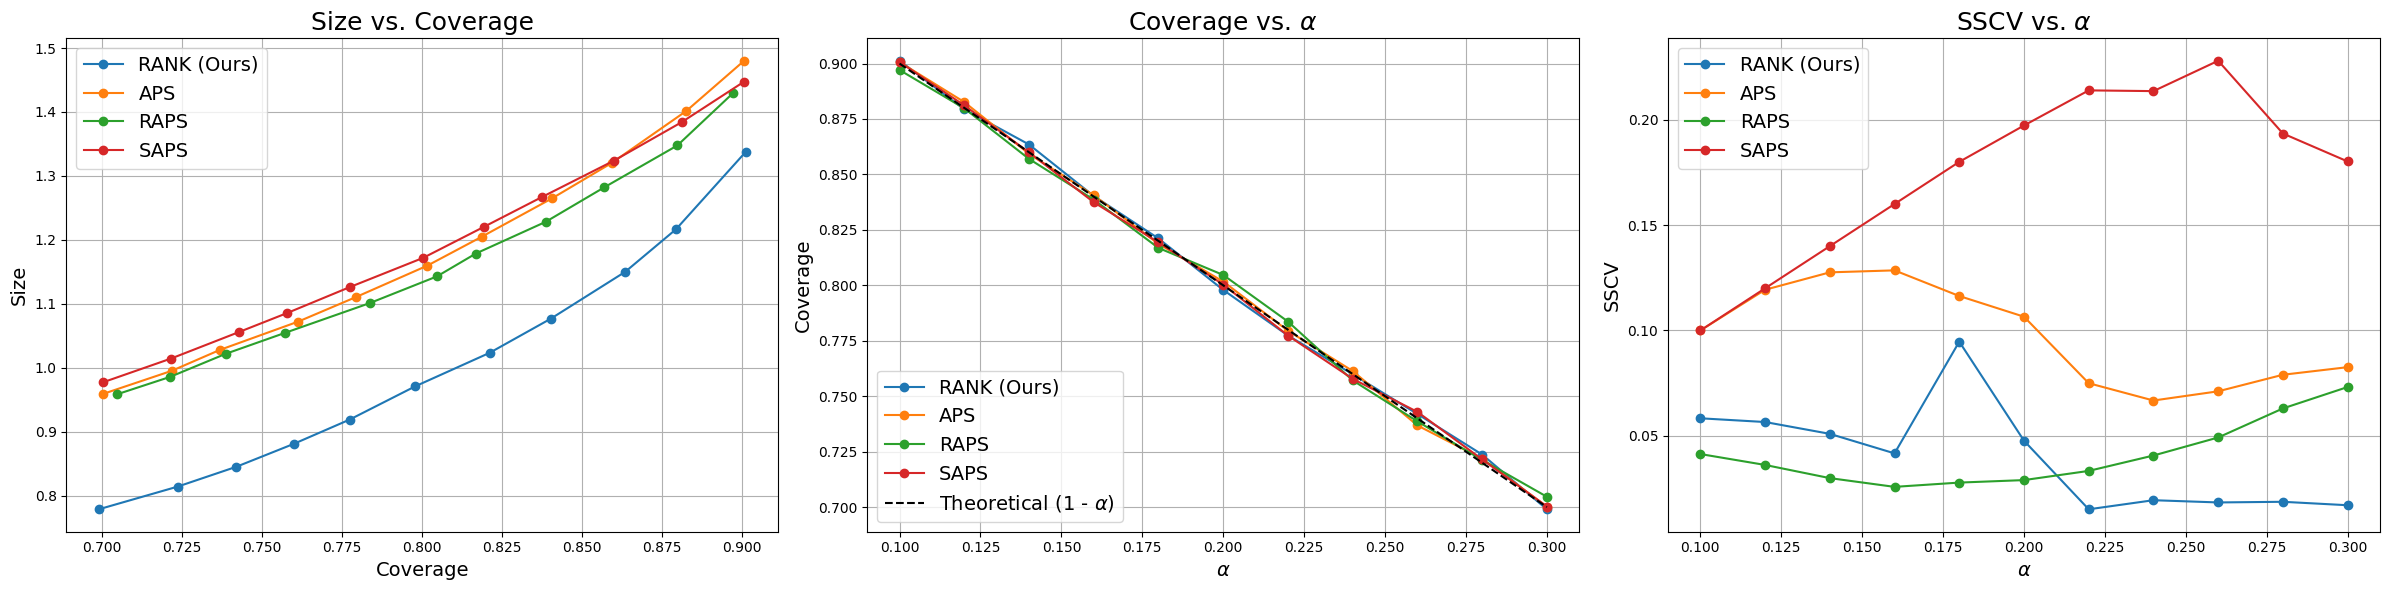

In [11]:
colors = plt.get_cmap("tab10")
names = ['THRRANK', 'APS', 'RAPS', 'SAPS']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Plot Size vs. Coverage
for idx, score_function in enumerate(score_functions):
    result = results_df[results_df['Score Function'] == names[idx]]
    if score_function == THRRANK:
        ax1.plot(result['Coverage'], result['Size'], color=colors(idx), linestyle='-', marker='o', label="RANK (Ours)")
    else:
        ax1.plot(result['Coverage'], result['Size'], color=colors(idx), linestyle='-', marker='o', label=names[idx])

ax1.set_xlabel('Coverage', fontsize=14)
ax1.set_ylabel('Size', fontsize=14)
ax1.set_title('Size vs. Coverage', fontsize=18)
ax1.legend(loc='upper left', fontsize=14)
ax1.grid(True)

# Plot Coverage vs. Alpha
for idx, score_function in enumerate(score_functions):
    result = results_df[results_df['Score Function'] == names[idx]]
    if score_function == THRRANK:
        ax2.plot(result['Alpha'], result['Coverage'], color=colors(idx), linestyle='-', marker='o', label="RANK (Ours)")
    else:
        ax2.plot(result['Alpha'], result['Coverage'], color=colors(idx), linestyle='-', marker='o', label=names[idx])

# Generate the theoretical line 1 - alpha
theoretical_coverage = [1 - alpha for alpha in alphas]
ax2.plot(alphas, theoretical_coverage, color='black', linestyle='--', label='Theoretical (1 - $\\alpha$)')

ax2.set_xlabel('$\\alpha$', fontsize=14)
ax2.set_ylabel('Coverage', fontsize=14)
ax2.set_title('Coverage vs. $\\alpha$', fontsize=18)
ax2.legend(loc='lower left', fontsize=14)
ax2.grid(True)

# Plot Alpha vs. SSCV
for idx, score_function in enumerate(score_functions):
    result = results_df[results_df['Score Function'] == names[idx]]
    if score_function == THRRANK:
        ax3.plot(result['Alpha'], result['SSCV'], color=colors(idx), linestyle='-', marker='o', label="RANK (Ours)")
    else:
        ax3.plot(result['Alpha'], result['SSCV'], color=colors(idx), linestyle='-', marker='o', label=names[idx])

ax3.set_xlabel('$\\alpha$', fontsize=14)
ax3.set_ylabel('SSCV', fontsize=14)
ax3.set_title('SSCV vs. $\\alpha$', fontsize=18)
ax3.legend(loc='upper left', fontsize=14)
ax3.grid(True)

plt.tight_layout()
plt.show()
fig.savefig('tweet_emotion.pdf')

In [12]:
results_df.to_csv('tweets_emotion.csv')